In [23]:
!pip install torchinfo

In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tabulate import tabulate
from torchinfo import summary
import csv

In [25]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Set paths for dataset splits
train_dir = 'I:/RICE/final_rice_data/train'
val_dir = 'I:/RICE/final_rice_data/val'
test_dir = 'I:/RICE/final_rice_data/test'

In [27]:
# Function to count images in a directory
def count_images_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each directory
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

# Display the counts
print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the validation set: {val_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 10000
Total number of images in the validation set: 1250
Total number of images in the test set: 1250


In [28]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(20),            # Random rotation
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])

In [29]:
# Normalization for validation and test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [30]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [31]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
# Define the DenseNet model architecture
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)  # Load DenseNet-121 with pretrained weights
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)  # Modify the classifier

    def forward(self, x):
        return self.densenet(x)

num_classes = 5  # Number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel(num_classes).to(device)

In [33]:
# Display model summary
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNetModel                                 [1, 5]                    --
├─DenseNet: 1-1                               [1, 5]                    --
│    └─Sequential: 2-1                        [1, 1024, 7, 7]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
│    │    └─_DenseBlock: 3-5                  [1, 256, 56, 56]          335,040
│    │    └─_Transition: 3-6                  [1, 128, 28, 28]          33,280
│    │    └─_DenseBlock: 3-7                  [1, 512, 28, 28]          919,680
│    │    └─_Transition: 3-8                  [1, 256, 14, 14]          132,096
│    │    └─_DenseBlock: 3-9                  [1, 1024, 14, 14]         

In [34]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [35]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc= "Training", leave = False):
        images, labels = images.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

    train_loss = running_loss / len(train_loader)  # Average loss
    train_accuracy = 100*correct / total  # Accuracy
    return train_loss, train_accuracy


In [36]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [37]:
# Define a function to train and validate the model with early stopping
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []  # To store training accuracy

    best_val_accuracy = 0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Append to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)  # Store training accuracy

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Accuracy: {train_accuracy:.4f} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation Loss: {val_loss:.4f}")

        # Check if we have a new best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_crack_detection_model.pth')
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}%")
        else:
            epochs_without_improvement += 1
        
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch + 1}.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [38]:
# Train and evaluate the model
num_epochs = 40
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/40 - Training Accuracy: 35.1600 - Training Loss: 1.4603 - Validation Accuracy: 50.3200 - Validation Loss: 1.2931
Best model saved with accuracy: 50.3200%


Epoch 2/40 - Training Accuracy: 62.3900 - Training Loss: 1.1006 - Validation Accuracy: 69.3600 - Validation Loss: 0.9585
Best model saved with accuracy: 69.3600%


Epoch 3/40 - Training Accuracy: 77.5900 - Training Loss: 0.8311 - Validation Accuracy: 76.4800 - Validation Loss: 0.7371
Best model saved with accuracy: 76.4800%


Epoch 4/40 - Training Accuracy: 83.6500 - Training Loss: 0.6469 - Validation Accuracy: 87.8400 - Validation Loss: 0.5418
Best model saved with accuracy: 87.8400%


Epoch 5/40 - Training Accuracy: 87.9700 - Training Loss: 0.5139 - Validation Accuracy: 90.1600 - Validation Loss: 0.4356
Best model saved with accuracy: 90.1600%


Epoch 6/40 - Training Accuracy: 89.8900 - Training Loss: 0.4178 - Validation Accuracy: 92.0800 - Validation Loss: 0.3451
Best model saved with accuracy: 92.0800%


Epoch 7/40 - Training Accuracy: 90.9500 - Training Loss: 0.3499 - Validation Accuracy: 93.6000 - Validation Loss: 0.2768
Best model saved with accuracy: 93.6000%


Epoch 8/40 - Training Accuracy: 92.5800 - Training Loss: 0.2922 - Validation Accuracy: 93.9200 - Validation Loss: 0.2476
Best model saved with accuracy: 93.9200%


Epoch 9/40 - Training Accuracy: 93.2000 - Training Loss: 0.2575 - Validation Accuracy: 95.4400 - Validation Loss: 0.1983
Best model saved with accuracy: 95.4400%


Epoch 10/40 - Training Accuracy: 94.1800 - Training Loss: 0.2277 - Validation Accuracy: 96.1600 - Validation Loss: 0.1738
Best model saved with accuracy: 96.1600%


Epoch 11/40 - Training Accuracy: 94.7000 - Training Loss: 0.2011 - Validation Accuracy: 96.2400 - Validation Loss: 0.1532
Best model saved with accuracy: 96.2400%


Epoch 12/40 - Training Accuracy: 95.1600 - Training Loss: 0.1792 - Validation Accuracy: 97.0400 - Validation Loss: 0.1338
Best model saved with accuracy: 97.0400%


Epoch 13/40 - Training Accuracy: 95.6900 - Training Loss: 0.1584 - Validation Accuracy: 97.1200 - Validation Loss: 0.1273
Best model saved with accuracy: 97.1200%


Epoch 14/40 - Training Accuracy: 95.6800 - Training Loss: 0.1536 - Validation Accuracy: 96.6400 - Validation Loss: 0.1151


Epoch 15/40 - Training Accuracy: 96.0800 - Training Loss: 0.1397 - Validation Accuracy: 97.8400 - Validation Loss: 0.1004
Best model saved with accuracy: 97.8400%


Epoch 16/40 - Training Accuracy: 96.2600 - Training Loss: 0.1333 - Validation Accuracy: 97.0400 - Validation Loss: 0.1063


Epoch 17/40 - Training Accuracy: 96.6100 - Training Loss: 0.1244 - Validation Accuracy: 97.2800 - Validation Loss: 0.0977


Epoch 18/40 - Training Accuracy: 96.5200 - Training Loss: 0.1258 - Validation Accuracy: 98.0800 - Validation Loss: 0.0807
Best model saved with accuracy: 98.0800%


Epoch 19/40 - Training Accuracy: 96.9600 - Training Loss: 0.1096 - Validation Accuracy: 97.6800 - Validation Loss: 0.0806


Epoch 20/40 - Training Accuracy: 97.1400 - Training Loss: 0.1038 - Validation Accuracy: 98.0000 - Validation Loss: 0.0734


Epoch 21/40 - Training Accuracy: 97.2100 - Training Loss: 0.0970 - Validation Accuracy: 98.3200 - Validation Loss: 0.0778
Best model saved with accuracy: 98.3200%


Epoch 22/40 - Training Accuracy: 97.2700 - Training Loss: 0.0971 - Validation Accuracy: 98.2400 - Validation Loss: 0.0652


Epoch 23/40 - Training Accuracy: 97.3400 - Training Loss: 0.0918 - Validation Accuracy: 98.0800 - Validation Loss: 0.0697


Epoch 24/40 - Training Accuracy: 97.5000 - Training Loss: 0.0844 - Validation Accuracy: 98.4000 - Validation Loss: 0.0599
Best model saved with accuracy: 98.4000%


Epoch 25/40 - Training Accuracy: 97.4600 - Training Loss: 0.0866 - Validation Accuracy: 98.4800 - Validation Loss: 0.0531
Best model saved with accuracy: 98.4800%


Epoch 26/40 - Training Accuracy: 97.6800 - Training Loss: 0.0825 - Validation Accuracy: 98.4800 - Validation Loss: 0.0519


Epoch 27/40 - Training Accuracy: 97.9200 - Training Loss: 0.0739 - Validation Accuracy: 98.5600 - Validation Loss: 0.0514
Best model saved with accuracy: 98.5600%


Epoch 28/40 - Training Accuracy: 97.8000 - Training Loss: 0.0756 - Validation Accuracy: 97.6800 - Validation Loss: 0.0717


Epoch 29/40 - Training Accuracy: 97.8900 - Training Loss: 0.0731 - Validation Accuracy: 98.5600 - Validation Loss: 0.0472


Epoch 30/40 - Training Accuracy: 98.1500 - Training Loss: 0.0660 - Validation Accuracy: 98.5600 - Validation Loss: 0.0474


Epoch 31/40 - Training Accuracy: 98.0700 - Training Loss: 0.0676 - Validation Accuracy: 98.4000 - Validation Loss: 0.0475


Epoch 32/40 - Training Accuracy: 98.1800 - Training Loss: 0.0640 - Validation Accuracy: 98.7200 - Validation Loss: 0.0420
Best model saved with accuracy: 98.7200%


Epoch 33/40 - Training Accuracy: 97.7600 - Training Loss: 0.0702 - Validation Accuracy: 98.0000 - Validation Loss: 0.0606


Epoch 34/40 - Training Accuracy: 98.1900 - Training Loss: 0.0629 - Validation Accuracy: 99.1200 - Validation Loss: 0.0398
Best model saved with accuracy: 99.1200%


Epoch 35/40 - Training Accuracy: 98.4100 - Training Loss: 0.0571 - Validation Accuracy: 98.5600 - Validation Loss: 0.0461


Epoch 36/40 - Training Accuracy: 98.3200 - Training Loss: 0.0559 - Validation Accuracy: 99.0400 - Validation Loss: 0.0338


Epoch 37/40 - Training Accuracy: 98.4700 - Training Loss: 0.0561 - Validation Accuracy: 98.7200 - Validation Loss: 0.0369


Epoch 38/40 - Training Accuracy: 98.1800 - Training Loss: 0.0575 - Validation Accuracy: 98.7200 - Validation Loss: 0.0375


Epoch 39/40 - Training Accuracy: 98.3100 - Training Loss: 0.0571 - Validation Accuracy: 98.7200 - Validation Loss: 0.0384
Early stopping triggered. Stopping training at epoch 39.


In [39]:
# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0399, Test Accuracy: 98.96%


In [40]:
# Save accuracy and loss to a CSV file
with open('DenseNet_training_results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])
    for epoch in range(len(train_losses)):  # Use len(train_losses) instead of num_epochs
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])

print("Training results saved to DenseNet_training_results.csv")

Training results saved to DenseNet_training_results.csv


In [41]:
# Optionally save the final model (this is optional since best model is already saved)
torch.save(model.state_dict(), 'densenet_rice_model.pth')
print("Model training complete and saved as 'densenet_rice_model.pth'.")

Model training complete and saved as 'densenet_rice_model.pth'.


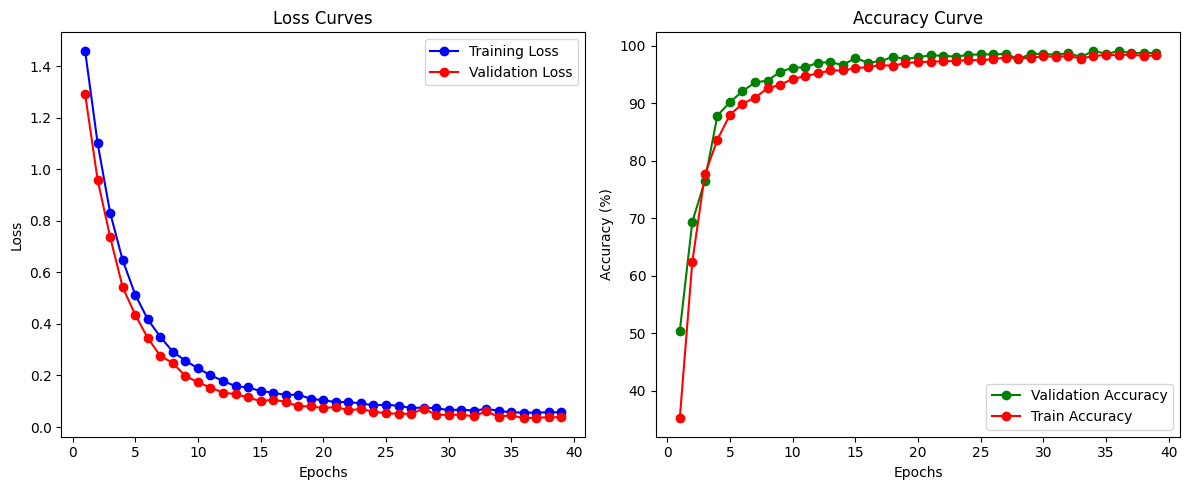

In [42]:
# Plotting accuracy and loss curves
def plot_curves(train_losses, val_losses, val_accuracies, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.plot(epochs, train_accuracies, 'ro-', label='Train Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(train_losses, val_losses, val_accuracies, train_accuracies)